In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import NEAREST
import numpy as np
import cv2
import os
import imutils
from random import random, seed, randint

from scipy import ndimage as ndi
from scipy.spatial.distance import euclidean
from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from torchvision.transforms.functional import pad, resized_crop, resize, center_crop, rotate, hflip, to_pil_image
# from torch.random import torch.random.manual_seed(seed)

from processing import *

IMAGES_LIMIT = 5000

In [2]:
# o=get_origs()
# get_clahes(o)
# cell_masks = get_cell_masks()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)

# pimg(weight_maps[1])

def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)

In [3]:
def get_pred_masks():
    return get_binary_cell_masks(get_cell_masks())

def get_pred_markers(pred_masks, e_r):
    return get_binary_cell_markers(get_cell_masks(), e_r)

In [4]:
def threshold_binary_image(img, thresh=0.5):
    image = img.copy()
    return (image*1.0 >= thresh).astype('uint8')

E:\VMShared\vision_group_c\processing.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(origs)
<ipython-input-5-5b6f3cd5b766>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(out.shape, h, w, str(np.alltrue(inp == out)))


(700, 1100)
(704, 1104) 4 4 False
(700, 1100) True


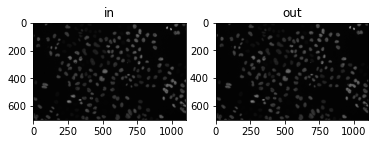

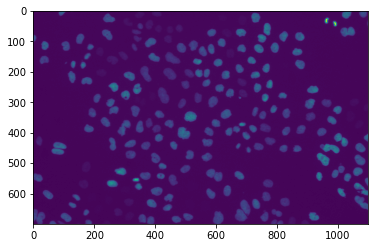

In [5]:
inp = get_origs()[0]
print(inp.shape)
out, (h, w) = get_padded16(inp)
print(out.shape, h, w, str(np.alltrue(inp == out)))
un_pad = get_unpadded(out, h, w)
print(un_pad.shape, str(np.alltrue(inp == un_pad)))
plot_two_images(inp, out, "in", "out")
pimg(un_pad)

In [6]:
# def img_aug(dataset, new_prefix = "_aug"):
#     #constants
#     num_aug_multiplier = 17
    
#     new_dir_name = dataset + new_prefix
    
#     try:
#         os.mkdir(new_dir_name)
#         os.mkdir(os.path.join(new_dir_name, "originals"))
#         os.mkdir(os.path.join(new_dir_name, "masks"))
#     except:
#         print("One of the directories to be created already exists. Clear and try again.")
#         return
    
#     data = []
#     paths = [dataset + '/01', dataset + '/02']
#     count = 0
    
#     for path in paths:
#         mask_path = path + '_ST'
#         mask_path = os.path.join(mask_path, "SEG")
        
#         for f in os.listdir(mask_path):
#             if count >= IMAGES_LIMIT:
#                 break

#             if not f.endswith(".tif"):
#                 continue
#             image_np = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
#             mask_np = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            
# #             image_pil = Image.open( os.path.join(path, f.replace('man_seg', 't')) )
# #             mask_pil = Image.open( os.path.join(mask_path, f) )
#             image_pil = to_pil_image(image_np)
#             mask_pil = Image.open( os.path.join(mask_path, f) )
#             mask_pil = mask_pil.convert("L")

#             print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
#             index = 't' + str(count) + ".tif"
#             count += 1
            
#             cv2.imwrite(os.path.join(new_dir_name, "originals", index ), image_np)
#             cv2.imwrite(os.path.join(new_dir_name, "masks", index ), mask_np)
            
#             for i in range(num_aug_multiplier):
#                 new_img = None
#                 new_mask = None
#                 image = image_pil
#                 mask = mask_pil
                
#                 seed()
#                 seed_ = randint(0,1000)
                
#                 index = 't' + str(count) + ".tif"
#                 count += 1
                
#                 seed(seed_)
#                 if random() > 0.5:
#                     pad_size = int(randint(0,int(image.height*0.2)))
#                     pad_size = (pad_size)
#                     new_img = pad(image, pad_size, padding_mode='reflect')
#                     new_img = resize(new_img, (image.height, image.width))
#                 else:
#                     t_size = image.height * (0.6 + ( random() * 0.39 ) )
#                     new_img = center_crop(image, (t_size, t_size))
#                     new_img = resize(new_img, (image.height, image.width) )
                
#                 pad_size = int(image.height*0.5)
#                 pad_size = (pad_size)
#                 new_img = pad(new_img, pad_size, padding_mode='reflect')
#                 new_img = rotate(new_img, randint(0,360), expand=False, fill=0)
# #                 new_img = resize(new_img, (image.height, image.width) )
#                 new_img = center_crop(new_img, (image.height, image.width) )
                
#                 new_img = hflip(new_img)
#                 new_img.save( os.path.join(new_dir_name, "originals", index) )
                
#                 seed(seed_)
#                 if random() > 0.5:
#                     pad_size = int(randint(0, int(mask.height*0.2)))
#                     pad_size = (pad_size)
#                     new_mask = pad(mask, pad_size, padding_mode='reflect')
#                     new_mask = resize(new_mask, (mask.height, mask.width), interpolation=NEAREST)
#                 else:
#                     t_size = mask.height * (0.6 + ( random() * 0.39 ) )
#                     new_mask = center_crop(mask, (t_size, t_size) )
#                     new_mask = resize(new_mask, (mask.height, mask.width), interpolation=NEAREST)
                
#                 pad_size = int(mask.height*0.5)
#                 pad_size = (pad_size)
#                 new_mask = pad(new_mask, pad_size, padding_mode='reflect')
#                 new_mask = rotate(new_mask, randint(0,360), expand=False, fill=0)
# #                 new_mask = resize(new_mask, (mask.height, mask.width), interpolation=NEAREST )
#                 new_mask = center_crop(new_mask, (mask.height, mask.width) )
                
#                 new_mask = hflip(new_mask)
#                 new_mask.save( os.path.join(new_dir_name, "masks", index ) )
                
# #                 plot_two_images(mask, new_mask, "Gen Img", "Gen Mask")
# #                 plot_two_images(new_img, get_markers(np.asarray(new_mask), 2), "img", "markers")
# #                 print(len(np.unique(np.asarray(mask))) - len(np.unique(np.asarray(new_mask))), np.unique(np.asarray(mask)), np.unique(np.asarray(new_mask)))
                
# #                 assert(len(np.unique(np.asarray(mask))) - len(np.unique(np.asarray(new_mask))) == 0)
    
#                 print(index)
#     print("Finished.")
                
# img_aug("PhC-2")

In [7]:
# def create_preprocessed_cache(dataset, new_dir_name=None):
#     #constants
#     EROS_RADIUS=1
#     CL = 2.0
#     TGS = (8, 8)

#     if new_dir_name == None:
#         new_dir_name = dataset+"_cache"
    
#     try:
#         os.mkdir(new_dir_name)
#         os.mkdir(os.path.join(new_dir_name, "originals"))
#         os.mkdir(os.path.join(new_dir_name, "clahes"))
#         os.mkdir(os.path.join(new_dir_name, "masks"))
#         os.mkdir(os.path.join(new_dir_name, "markers"))
#         os.mkdir(os.path.join(new_dir_name, "weight_maps"))
#     except:
#         print("One of the directories to be created already exists. Clear and try again.")
#         return
    
#     data = []
#     paths = [dataset + '/01', dataset + '/02']
#     count = 0
    
#     for path in paths:
#         mask_path = path + '_ST'
#         mask_path = os.path.join(mask_path, "SEG")
        
#         for f in os.listdir(mask_path):
#             if count >= IMAGES_LIMIT:
#                 break
            
#             if not f.endswith(".tif"):
#                 continue
#             image = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
#             clahe = equalize_clahe(image, CL, TGS).astype(np.float32)
#             mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
#             print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
# #             # WARNING: ONLY FOR FLUO, DISABLE FOR OTHERS. ASSUMES MASK SHAPE IS SAME AS IMAGE SHAPE
# #             image, _ = get_padded16(image)
# #             clahe, padding_dimpair = get_padded16(clahe)
# #             mask, _ = get_padded16(mask)
            
#             # Generate the Cell Mask and Markers from the Mask
#             cell_mask = (mask > 0).astype(np.uint8)
#             markers = (get_markers(mask, EROS_RADIUS) > 0).astype(np.uint8)
#             weight_map = get_weight_map(markers)
            
#             index = 't' + str(count) + ".npy"
#             count += 1 
            
#             np.save(os.path.join(new_dir_name, "originals", index ), image)
#             np.save(os.path.join(new_dir_name, "clahes", index ), clahe)
#             np.save(os.path.join(new_dir_name, "masks", index ), cell_mask)
#             np.save(os.path.join(new_dir_name, "markers", index ), markers)
#             np.save(os.path.join(new_dir_name, "weight_maps", index ), weight_map)
            
# #             cv2.imwrite(os.path.join(new_dir_name, "originals", index ), image)
# #             cv2.imwrite(os.path.join(new_dir_name, "clahes", index ), clahe)
# #             cv2.imwrite(os.path.join(new_dir_name, "masks", index ), cell_mask)
# #             cv2.imwrite(os.path.join(new_dir_name, "markers", index ), markers)
# #             cv2.imwrite(os.path.join(new_dir_name, "weight_maps", index ), weight_map)
    
#             print(count)
# #             plot_two_images(clahe, cell_mask, "orig", "mask")
# #             plot_two_images(markers, weight_map, "marker", "weight map")

# create_preprocessed_cache('PhC-3', new_dir_name=None)

In [8]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[1]
# b = get_clahes(origs)[1]
# c = cell_masks[1]
# d = cell_markers[1]

# h = weight_maps[1]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)

383 350 [  0.  67.  68.  69.  70.  71.  72.  73.  74.  76.  77.  78.  79.  80.
  81.  83.  84.  85.  86.  87.  88.  90.  91.  92.  93.  94.  95.  97.
  98.  99. 100. 101. 103. 104. 105. 106. 107. 109. 110. 111. 112. 114.
 115. 116. 117. 119. 120. 121. 122. 123. 125. 126. 127. 128. 130. 131.
 132. 134. 135. 136. 137. 139. 140. 141. 142. 144. 145. 146. 148. 149.
 150. 151. 153. 154. 155. 157. 158. 159. 161. 162. 163. 165. 166. 167.
 168. 170. 171. 172. 174. 175. 176. 178. 179. 180. 182. 183. 184. 186.
 187. 188. 190. 191. 193. 194. 195. 197. 198. 199. 201. 202. 203. 205.
 206. 207. 209. 210. 212. 213. 214. 216. 217. 219. 220. 221. 223. 224.
 225. 227. 228. 230. 231. 232. 234. 235. 237. 238. 239. 241. 242. 244.
 245. 246. 248. 249. 251. 252. 254. 255.]


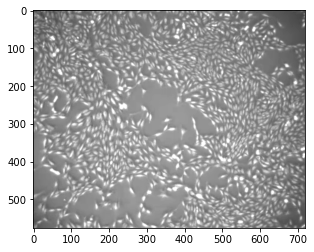

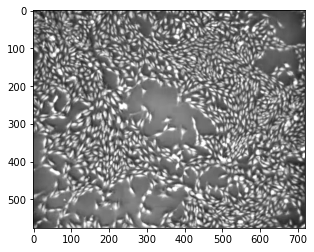

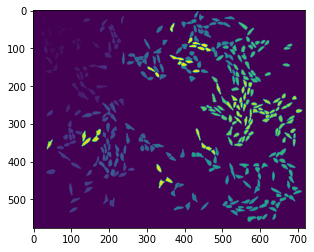

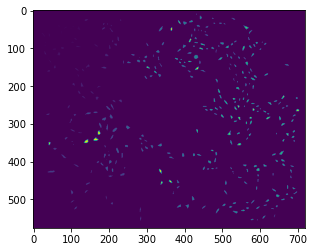

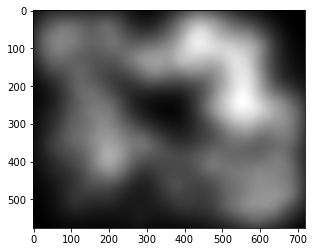

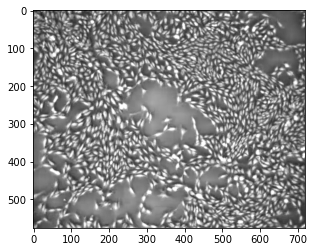

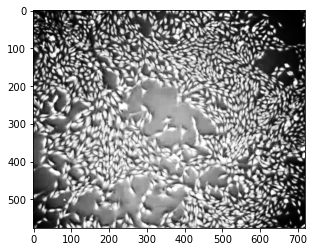

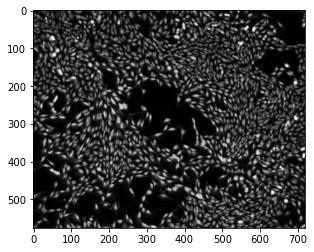

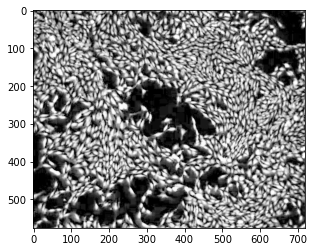

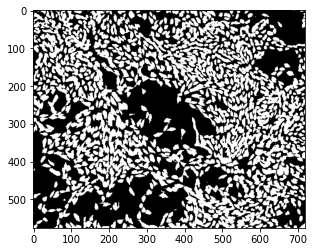

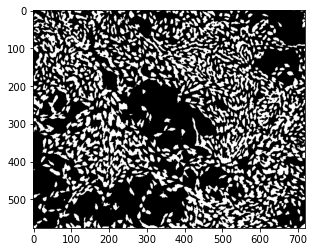

In [9]:
# MAX_PIX_VAL = 255
# MIN_PIX_VAL = 0

# def cont_stretch(img):
#     image = img.copy()
#     max_pixel = np.amax(image)
#     min_pixel = np.amin(image)

#     image = ( (image-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) )
#     image += MIN_PIX_VAL
    
#     return image
    
# #     for r in range(image.shape[0]):
# #         for c in range(image.shape[1]):
# #             image[r,c] = ( (image[r,c]-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) ) + MIN_PIX_VAL

# cell_masks = get_cell_masks(r"PhC-2\01_ST\SEG")
# origs = get_origs(r"PhC-2\01")
# cell_markers = get_markers(cell_masks[90], 3)
# weight_maps = get_weight_map(cell_markers, False)

# a = origs[100]
# a = cv2.imread(r"PhC-2\01\t424.tif", cv2.IMREAD_GRAYSCALE).astype('uint8')

# b = equalize_clahe(a)
# c = cell_masks[100]
# d = cell_markers

# h = weight_maps

# i = equalize_clahe(a,2, (20,20))

# j = cv2.equalizeHist((a))
# # j = (cont_stretch(i) > 127).astype('uint8')
# # j =cv2.fastNlMeansDenoising(j, h=1)
# print(len(np.unique(c))-1, len(np.unique(d)-1), np.unique(cont_stretch(a)))

# def max_filter(image, n):
#     A_image = image.copy()

#     for r in range(image.shape[0]):
#         for c in range(image.shape[1]):
#             start_r = max(r - (n//2), 0)
#             end_r = min(r + (n//2), image.shape[0]) 
#             start_c = max(c - (n//2), 0)
#             end_c = min(c + (n//2), image.shape[1])

#             temp_img = image[start_r:(end_r+1), start_c:(end_c+1)]
#             A_image[r,c] = np.amax(temp_img)

#     return A_image

# def min_filter(image, n):
#     B_image = image.copy()

#     for r in range(image.shape[0]):
#         for c in range(image.shape[1]):
#             start_r = max(r - (n//2), 0)
#             end_r = min(r + (n//2), image.shape[0]) 
#             start_c = max(c - (n//2), 0)
#             end_c = min(c + (n//2), image.shape[1])

#             temp_img = image[start_r:(end_r+1), start_c:(end_c+1)]
#             B_image[r,c] = np.amin(temp_img)

#     return B_image

# min_fil_img = min_filter(a, 20)
# max_fil_img = max_filter(min_fil_img, 20)
# O_img = a-max_fil_img
# O_img = cont_stretch(O_img)

# k = cv2.equalizeHist(O_img.astype('uint8'))

# l = (k > 135).astype('uint8')

# m = cv2.erode(l, disk(1))

# # m = (a > 200).astype('uint8')

# pimg(a, grayscale=True)

# pimg(b, grayscale=True)

# pimg(c, grayscale=False)

# pimg(d, grayscale=False)

# pimg(h, grayscale=True)

# pimg(i, grayscale=True)

# pimg(j, grayscale=True)

# pimg(O_img, grayscale=True)

# pimg(k, grayscale=True)

# pimg(l, grayscale=True)

# pimg(m, grayscale=True)

131 2 [0.00000000e+00 1.32158590e-01 1.98237885e-01 ... 2.51497797e+02
 2.52422907e+02 2.55000000e+02]


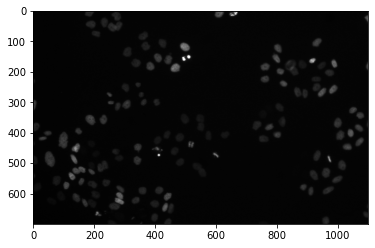

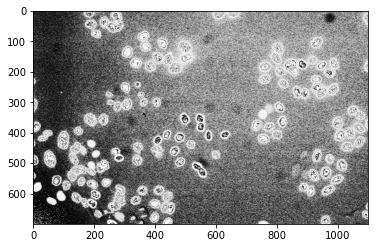

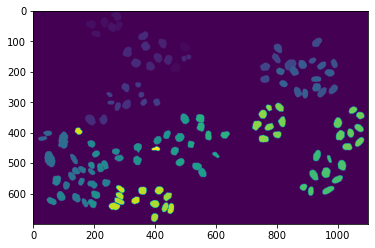

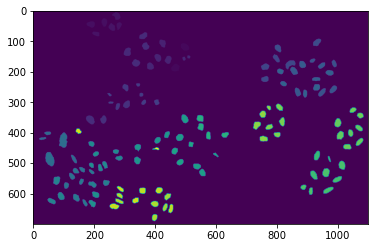

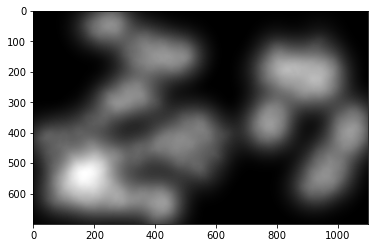

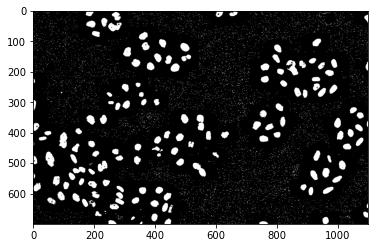

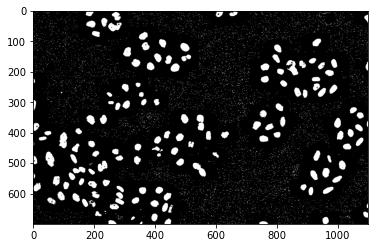

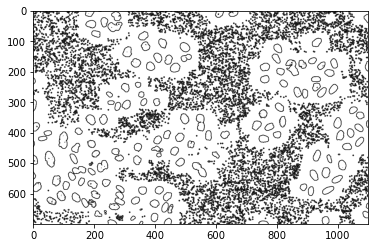

In [22]:
MAX_PIX_VAL = 255
MIN_PIX_VAL = 0

def cont_stretch(img):
    image = img.copy()
    max_pixel = np.amax(image)
    min_pixel = np.amin(image)

    image = ( (image-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) )
    image += MIN_PIX_VAL
    
    return image
    
#     for r in range(image.shape[0]):
#         for c in range(image.shape[1]):
#             image[r,c] = ( (image[r,c]-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) ) + MIN_PIX_VAL

cell_masks = get_cell_masks(r"Fluo-2\01_ST\SEG")
origs = get_origs(r"Fluo-2\01")
cell_markers = get_markers(cell_masks[90], 3)
weight_maps = get_weight_map(cell_markers, False)

a = origs[90]
b = equalize_clahe(origs[90])
b = cv2.equalizeHist(a.astype('uint8'))
c = cell_masks[90]
d = cell_markers

h = weight_maps

i = ( cont_stretch(equalize_clahe(origs[90],2, (34,34))) > 127).astype('uint8')

j = (cont_stretch(i) > 127).astype('uint8')
# j =cv2.fastNlMeansDenoising(j, h=1)
print(len(np.unique(cell_masks[90]))-1, len(np.unique(cell_markers[90])-1), np.unique(cont_stretch(a)))

k = cv2.adaptiveThreshold(cont_stretch(i).astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,5,2)


pimg(a, grayscale=True)

pimg(b, grayscale=True)

pimg(c, grayscale=False)

pimg(d, grayscale=False)

pimg(h, grayscale=True)

pimg(i, grayscale=True)

pimg(j, grayscale=True)

pimg(k, grayscale=True)

In [20]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 2)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[2]
# b = get_clahes(origs)[2]
# c = cell_masks[2]
# d = cell_markers[2]

# h = weight_maps[2]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)